# Predictive Maintenance for Industrial Equipment - FD002 Dataset

## Project Objective
This notebook implements a predictive maintenance solution for the NASA Turbofan Jet Engine dataset (FD002 subset). 

The goal is to predict the Remaining Useful Life (RUL) of engines using sensor data to enable proactive maintenance, reducing downtime and costs.

## Import Libraries

In [5]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Masking
from tensorflow.keras.callbacks import EarlyStopping
import xgboost as xgb

# Configure visualization settings
%matplotlib inline
sns.set(style="whitegrid")

## Load and Inspect Data

In [6]:
# Define column names
columns = ['unit', 'cycle', 'op_setting1', 'op_setting2', 'op_setting3'] + [f'sensor{i}' for i in range(1, 22)]

# Load training, test, and RUL datasets
train = pd.read_csv('train_FD002.txt', sep=r'\s+', header=None, names=columns)
test = pd.read_csv('test_FD002.txt', sep=r'\s+', header=None, names=columns)
rul = pd.read_csv('RUL_FD002.txt', header=None, names=['rul'])
rul['unit'] = range(1, len(rul) + 1)

## Dataset Summary

In [7]:
# Display shapes
print(f"Train shape: {train.shape}")
print(f"Test shape: {test.shape}")
print(f"RUL shape: {rul.shape}")

Train shape: (53759, 26)
Test shape: (33991, 26)
RUL shape: (259, 2)


In [8]:
# Preview train data
train.head()

,unit,cycle,op_setting1,op_setting2,op_setting3,sensor1,sensor2,sensor3,sensor4,sensor5,...,sensor12,sensor13,sensor14,sensor15,sensor16,sensor17,sensor18,sensor19,sensor20,sensor21
0,1,1,34.9983,0.8400,100.0,449.44,555.32,1358.61,1137.23,5.48,...,183.06,2387.72,8048.56,9.3461,0.02,334,2223,100.00,14.73,8.8071
1,1,2,41.9982,0.8408,100.0,445.00,549.90,1353.22,1125.78,3.91,...,130.42,2387.66,8072.30,9.3774,0.02,330,2212,100.00,10.41,6.2665
2,1,3,24.9988,0.6218,60.0,462.54,537.31,1256.76,1047.45,7.05,...,164.22,2028.03,7864.87,10.8941,0.02,309,1915,84.93,14.08,8.6723
3,1,4,42.0077,0.8416,100.0,445.00,549.51,1354.03,1126.38,3.91,...,130.72,2387.61,8068.66,9.3528,0.02,329,2212,100.00,10.59,6.4701
4,1,5,25.0005,0.6203,60.0,462.54,537.07,1257.71,1047.93,7.05,...,164.31,2028.00,7861.23,10.8963,0.02,309,1915,84.93,14.13,8.5286


## Data Preparation

### Calculate RUL
Compute Remaining Useful Life for training data, capping at 130 cycles to reduce noise from early data.

In [9]:
# Add RUL to train data with clipping
max_rul = 130
max_cycles = train.groupby('unit')['cycle'].max().reset_index()
max_cycles.columns = ['unit', 'max_cycle']
train = train.merge(max_cycles, on='unit')
train['rul'] = train['max_cycle'] - train['cycle']
train['rul'] = np.minimum(train['rul'], max_rul) 
train = train.drop('max_cycle', axis=1)

### Cluster Operating Conditions
Group data into regimes based on operational settings using KMeans.

In [11]:
# Clustering operating conditions
op_settings = ['op_setting1', 'op_setting2', 'op_setting3']
kmeans = KMeans(n_clusters=6, random_state=42)
train['condition'] = kmeans.fit_predict(train[op_settings]) 
test['condition'] = kmeans.predict(test[op_settings])     

### Normalize Sensors
Apply regime-based normalization to sensor data to account for varying operating conditions.

In [13]:
# Regime-based normalization for sensors
sensors = [f'sensor{i}' for i in range(1, 22)]
means = train.groupby('condition')[sensors].mean()
stds = train.groupby('condition')[sensors].std()

for sensor in sensors:
    for cond in train['condition'].unique():
        mask_train = train['condition'] == cond
        mask_test = test['condition'] == cond
        if stds.loc[cond, sensor] > 0.001:  # Only normalize if standard deviation is significant
            train.loc[mask_train, sensor] = (train.loc[mask_train, sensor] - means.loc[cond, sensor]) / stds.loc[cond, sensor]
            test.loc[mask_test, sensor] = (test.loc[mask_test, sensor] - means.loc[cond, sensor]) / stds.loc[cond, sensor]
        else:
            train.loc[mask_train, sensor] = 0  
            test.loc[mask_test, sensor] = 0

### Remove Constant Sensors
Drop sensors with negligible variation to reduce noise.

In [14]:
# Filter out sensors with low variance
varying_sensors = [s for s in sensors if train[s].std() > 0.001]

# Normalize cycle
cycle_scaler = MinMaxScaler()
train['cycle_norm'] = cycle_scaler.fit_transform(train[['cycle']])
test['cycle_norm'] = cycle_scaler.transform(test[['cycle']])

# Define features for modeling
features = ['cycle_norm'] + varying_sensors

## EDA and Feature Engineering

### Objectives
- **Analyze Correlations**: Identify relationships between features and RUL.
- **Engineer Features**: Create rolling statistics (mean, standard deviation, slope) for XGBoost to capture temporal trends.

In [15]:
# Define function to calculate rolling slope
roll_window = 5
linreg = LinearRegression()

def calc_slope(x):
    if len(x) < 2:
        return 0
    x_vals = np.arange(len(x))
    slope = linreg.fit(x_vals.reshape(-1, 1), x).coef_[0]
    return slope

In [16]:
# Add rolling features for each varying sensor
for sensor in varying_sensors:
    # Rolling mean
    train[f'{sensor}_roll_mean'] = train.groupby('unit')[sensor].transform(lambda x: x.rolling(roll_window, min_periods=1).mean())
    test[f'{sensor}_roll_mean'] = test.groupby('unit')[sensor].transform(lambda x: x.rolling(roll_window, min_periods=1).mean())
    
    # Rolling std
    train[f'{sensor}_roll_std'] = train.groupby('unit')[sensor].transform(lambda x: x.rolling(roll_window, min_periods=1).std())
    test[f'{sensor}_roll_std'] = test.groupby('unit')[sensor].transform(lambda x: x.rolling(roll_window, min_periods=1).std())
    train[f'{sensor}_roll_std'] = train[f'{sensor}_roll_std'].fillna(0) 
    test[f'{sensor}_roll_std'] = test[f'{sensor}_roll_std'].fillna(0)
    
    # Rolling slope
    train[f'{sensor}_slope'] = train.groupby('unit')[sensor].transform(lambda x: x.rolling(roll_window, min_periods=1).apply(calc_slope))
    test[f'{sensor}_slope'] = test.groupby('unit')[sensor].transform(lambda x: x.rolling(roll_window, min_periods=1).apply(calc_slope))

In [17]:
# Define features including rolling statistics
xgb_features = features + [f'{s}_roll_mean' for s in varying_sensors] + [f'{s}_roll_std' for s in varying_sensors] + [f'{s}_slope' for s in varying_sensors]

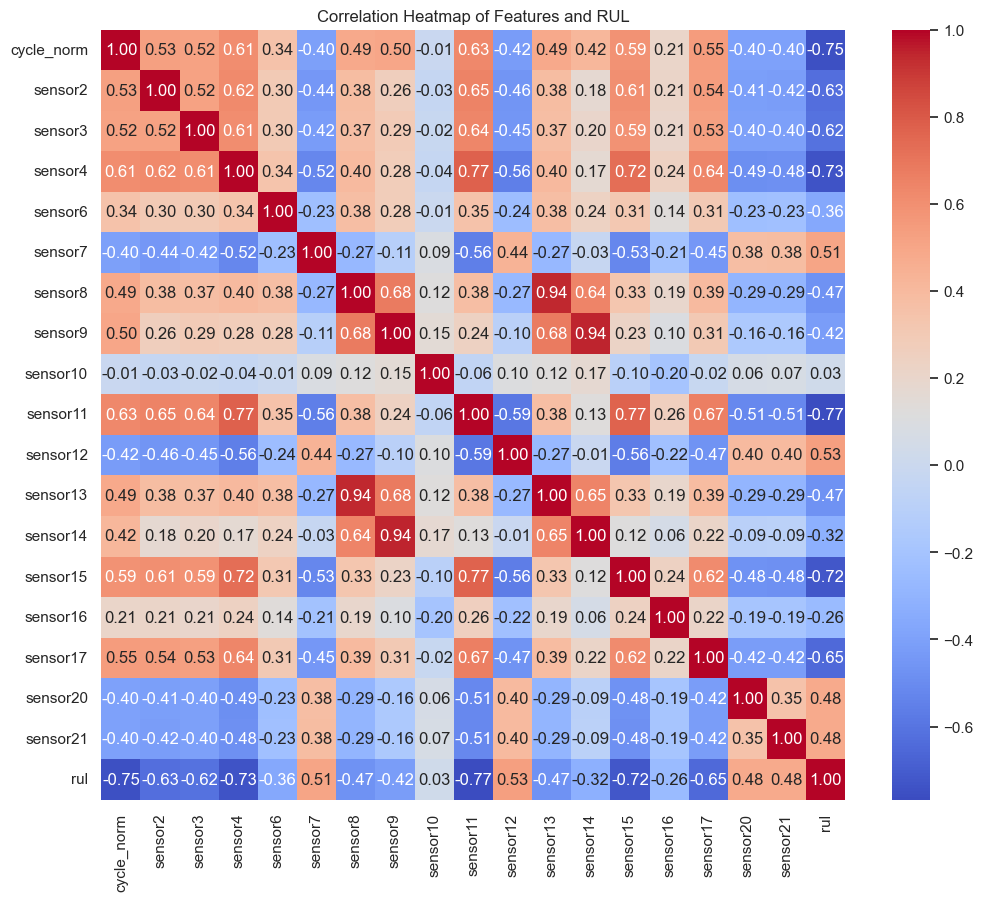

In [18]:
# Visualize correlations
corr = train[features + ['rul']].corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap of Features and RUL')
plt.show()

## Model Training and Validation

### Approach
- **Train-Validation Split**: Split data by engine units to prevent data leakage.
- **Models**:
  - **LSTM**: Capture temporal dependencies using sequence data.
  - **XGBoost**: Leverage engineered features for robust regression.

In [19]:
# Split training data into train and validation sets by unit
units = train['unit'].unique()
train_units, val_units = train_test_split(units, test_size=0.2, random_state=42)
train_idx = train['unit'].isin(train_units)
val_idx = train['unit'].isin(val_units)
train_data = train[train_idx]
val_data = train[val_idx]

### LSTM Model Training

In [20]:
# Function to create sequences for LSTM
def create_sequences(data, seq_length, features, label_col='rul'):
    xs, ys = [], []
    for unit in data['unit'].unique():
        unit_data = data[data['unit'] == unit]
        for start in range(len(unit_data) - seq_length + 1):
            end = start + seq_length
            x = unit_data[features].iloc[start:end].values 
            y = unit_data[label_col].iloc[end - 1]     
            xs.append(x)
            ys.append(y)
    return np.array(xs), np.array(ys)

In [21]:
# Prepare sequences for LSTM
seq_length = 30
X_train_seq, y_train_seq = create_sequences(train_data, seq_length, features)
X_val_seq, y_val_seq = create_sequences(val_data, seq_length, features)

# Build LSTM model
lstm_model = Sequential([
    Masking(mask_value=0., input_shape=(seq_length, len(features))), 
    LSTM(100, return_sequences=True),                           
    Dropout(0.2),                                            
    LSTM(50),                                                    
    Dropout(0.2),                                        
    Dense(1)                                                         
])
lstm_model.compile(optimizer='adam', loss='mean_squared_error')

c:\Users\Sara\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\masking.py:48: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [22]:
# Train LSTM model with early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
lstm_model.fit(X_train_seq, y_train_seq, epochs=100, batch_size=64, 
               validation_data=(X_val_seq, y_val_seq), callbacks=[early_stop], verbose=1)

Epoch 1/100
585/585 ━━━━━━━━━━━━━━━━━━━━ 16s 23ms/step - loss: 6597.8789 - val_loss: 3625.6223
Epoch 2/100
585/585 ━━━━━━━━━━━━━━━━━━━━ 13s 22ms/step - loss: 3384.4065 - val_loss: 1886.6588
Epoch 3/100
585/585 ━━━━━━━━━━━━━━━━━━━━ 13s 23ms/step - loss: 1792.2808 - val_loss: 995.7544
Epoch 4/100
585/585 ━━━━━━━━━━━━━━━━━━━━ 13s 23ms/step - loss: 965.2682 - val_loss: 567.5363
Epoch 5/100
585/585 ━━━━━━━━━━━━━━━━━━━━ 14s 23ms/step - loss: 563.9348 - val_loss: 382.6628
Epoch 6/100
585/585 ━━━━━━━━━━━━━━━━━━━━ 14s 23ms/step - loss: 374.6954 - val_loss: 329.4585
Epoch 7/100
585/585 ━━━━━━━━━━━━━━━━━━━━ 14s 23ms/step - loss: 289.1227 - val_loss: 268.8306
Epoch 8/100
585/585 ━━━━━━━━━━━━━━━━━━━━ 13s 23ms/step - loss: 234.5391 - val_loss: 246.8767
Epoch 9/100
585/585 ━━━━━━━━━━━━━━━━━━━━ 14s 23ms/step - loss: 216.6808 - val_loss: 274.5311
Epoch 10/100
585/585 ━━━━━━━━━━━━━━━━━━━━ 13s 23ms/step - loss: 182.1781 - val_loss: 363.9151
Epoch 11/100
585/585 ━━━━━━━━━━━━━━━━━━━━ 14s 23ms/step - loss: 

### LSTM Model Evaluation

In [23]:
# Evaluate LSTM on validation set
y_pred_val_lstm = lstm_model.predict(X_val_seq).flatten()
rmse_lstm = np.sqrt(mean_squared_error(y_val_seq, y_pred_val_lstm))
mae_lstm = mean_absolute_error(y_val_seq, y_pred_val_lstm)
r2_lstm = r2_score(y_val_seq, y_pred_val_lstm)

# Calculate MAPE, handling zero values
mask = y_val_seq != 0
mape_lstm = np.mean(np.abs((y_val_seq[mask] - y_pred_val_lstm[mask]) / y_val_seq[mask])) * 100
accuracy_lstm = 100 - mape_lstm

print(f"LSTM Validation RMSE: {rmse_lstm:.2f}")
print(f"LSTM Validation MAE: {mae_lstm:.2f}")
print(f"LSTM Validation R2 Score: {r2_lstm:.2f}")
print(f"LSTM Validation Accuracy (%): {accuracy_lstm:.2f}")

275/275 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
LSTM Validation RMSE: 15.71
LSTM Validation MAE: 11.70
LSTM Validation R2 Score: 0.87
LSTM Validation Accuracy (%): 80.46


### LSTM on Test Set

In [24]:
# Function to create test sequences with padding
def create_test_sequences(data, seq_length, features):
    xs = []
    for unit in data['unit'].unique():
        unit_data = data[data['unit'] == unit][features].values
        if len(unit_data) >= seq_length:
            xs.append(unit_data[-seq_length:]) 
        else:
            padded = np.zeros((seq_length, len(features)))
            padded[-len(unit_data):] = unit_data 
            xs.append(padded)
    return np.array(xs)

In [25]:
# Prepare test sequences and predict
X_test_seq = create_test_sequences(test, seq_length, features)
y_test = rul['rul'].values
y_pred_test_lstm = lstm_model.predict(X_test_seq).flatten()

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


In [26]:
# Evaluate LSTM on test set
rmse_test_lstm = np.sqrt(mean_squared_error(y_test, y_pred_test_lstm))
mae_test_lstm = mean_absolute_error(y_test, y_pred_test_lstm)
r2_test_lstm = r2_score(y_test, y_pred_test_lstm)

# Calculate MAPE, handling zero values
mask = y_test != 0
mape_test_lstm = np.mean(np.abs((y_test[mask] - y_pred_test_lstm[mask]) / y_test[mask])) * 100
accuracy_test_lstm = 100 - mape_test_lstm

print(f"LSTM Test RMSE: {rmse_test_lstm:.2f}")
print(f"LSTM Test MAE: {mae_test_lstm:.2f}")
print(f"LSTM Test R2 Score: {r2_test_lstm:.2f}")
print(f"LSTM Test Accuracy (%): {accuracy_test_lstm:.2f}")

LSTM Test RMSE: 26.34
LSTM Test MAE: 17.24
LSTM Test R2 Score: 0.76
LSTM Test Accuracy (%): 78.63


### Visualize LSTM Results

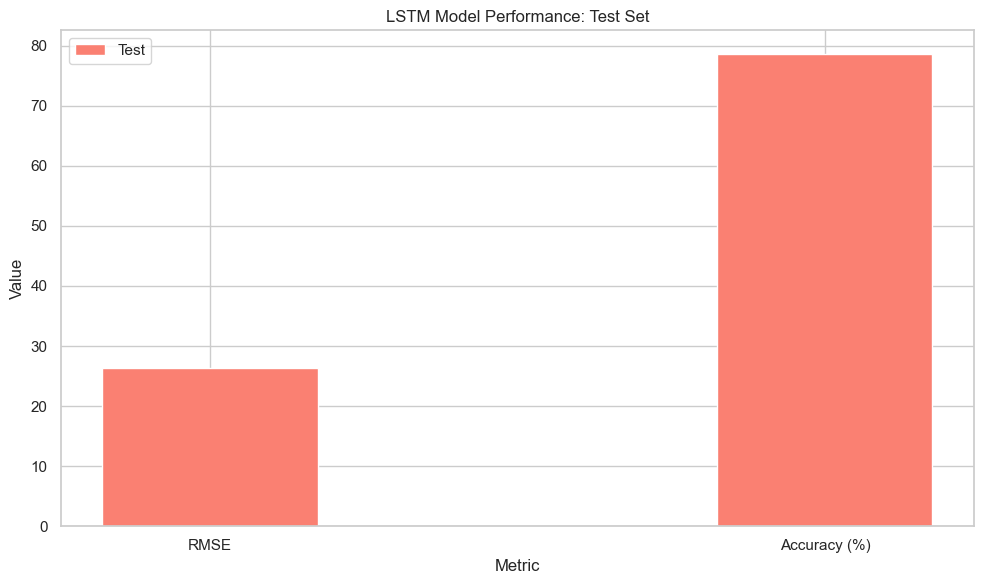

In [36]:
plt.figure(figsize=(10, 6))
metrics = ['RMSE', 'Accuracy (%)']
test_metrics = [rmse_test_lstm, accuracy_test_lstm]
x = np.arange(len(metrics))
width = 0.35

plt.bar(x, test_metrics, width, label='Test', color='salmon')
plt.xlabel('Metric')
plt.ylabel('Value')
plt.title('LSTM Model Performance: Test Set')
plt.xticks(x, metrics)
plt.legend()
plt.tight_layout()
plt.show()

### XGBoost Model Training and Evaluation

In [27]:
# Prepare data for XGBoost
test_last = test.groupby('unit').last().reset_index()
test_last = test_last.merge(rul, on='unit')
y_test_xgb = test_last['rul']

# Train XGBoost model
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
xgb_model.fit(train[train_idx][xgb_features], train[train_idx]['rul'])

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=None,
             n_jobs=None, num_parallel_tree=None, ...)

In [31]:
# Evaluate XGBoost on validation set
y_pred_val_xgb = xgb_model.predict(val_data[xgb_features])
rmse_xgb_val = np.sqrt(mean_squared_error(val_data['rul'], y_pred_val_xgb))
print(f"XGBoost Validation RMSE: {rmse_xgb_val:.2f}")
# Approximate accuracy percentage based on max RUL (130)
accuracy_xgb_val = (1 - rmse_xgb_val / 130) * 100
print(f"XGBoost Validation Accuracy (%): {accuracy_xgb_val:.2f}")

# Evaluate XGBoost on test set
y_pred_test_xgb = xgb_model.predict(test_last[xgb_features])
rmse_xgb_test = np.sqrt(mean_squared_error(y_test_xgb, y_pred_test_xgb))
print(f"XGBoost Test RMSE: {rmse_xgb_test:.2f}")
# Approximate accuracy percentage based on max RUL (130)
accuracy_xgb_test = (1 - rmse_xgb_test / 130) * 100
print(f"XGBoost Test Accuracy (%): {accuracy_xgb_test:.2f}")

XGBoost Validation RMSE: 17.59
XGBoost Validation Accuracy (%): 86.47
XGBoost Test RMSE: 27.04
XGBoost Test Accuracy (%): 79.20


### Visualize XGBoost Results

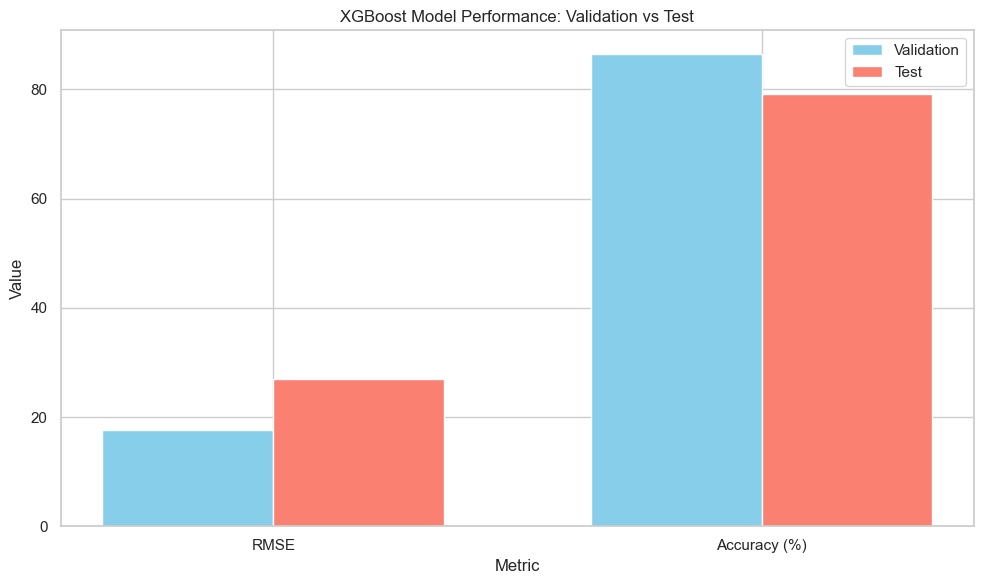

In [33]:
# Bar Chart for RMSE and Accuracy
plt.figure(figsize=(10, 6))
metrics = ['RMSE', 'Accuracy (%)']
val_metrics = [rmse_xgb_val, accuracy_xgb_val]
test_metrics = [rmse_xgb_test, accuracy_xgb_test]
x = np.arange(len(metrics))
width = 0.35

plt.bar(x - width/2, val_metrics, width, label='Validation', color='skyblue')
plt.bar(x + width/2, test_metrics, width, label='Test', color='salmon')
plt.xlabel('Metric')
plt.ylabel('Value')
plt.title('XGBoost Model Performance: Validation vs Test')
plt.xticks(x, metrics)
plt.legend()
plt.tight_layout()
plt.show()

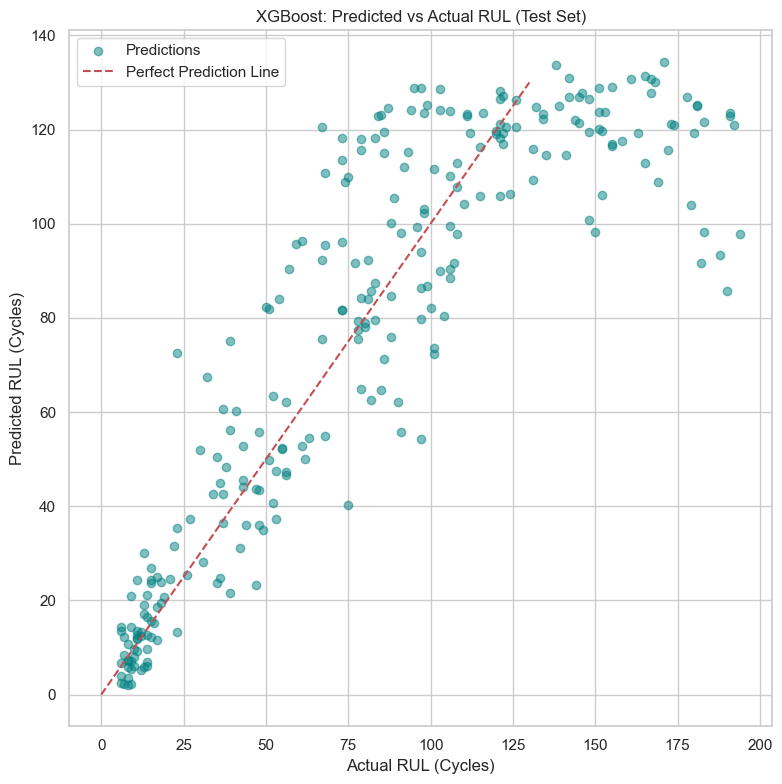

In [34]:
# Scatter Plot for Predicted vs Actual RUL (Test Set)
plt.figure(figsize=(8, 8))
plt.scatter(y_test_xgb, y_pred_test_xgb, alpha=0.5, color='teal', label='Predictions')
plt.plot([0, 130], [0, 130], 'r--', label='Perfect Prediction Line')
plt.xlabel('Actual RUL (Cycles)')
plt.ylabel('Predicted RUL (Cycles)')
plt.title('XGBoost: Predicted vs Actual RUL (Test Set)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Model Comparison

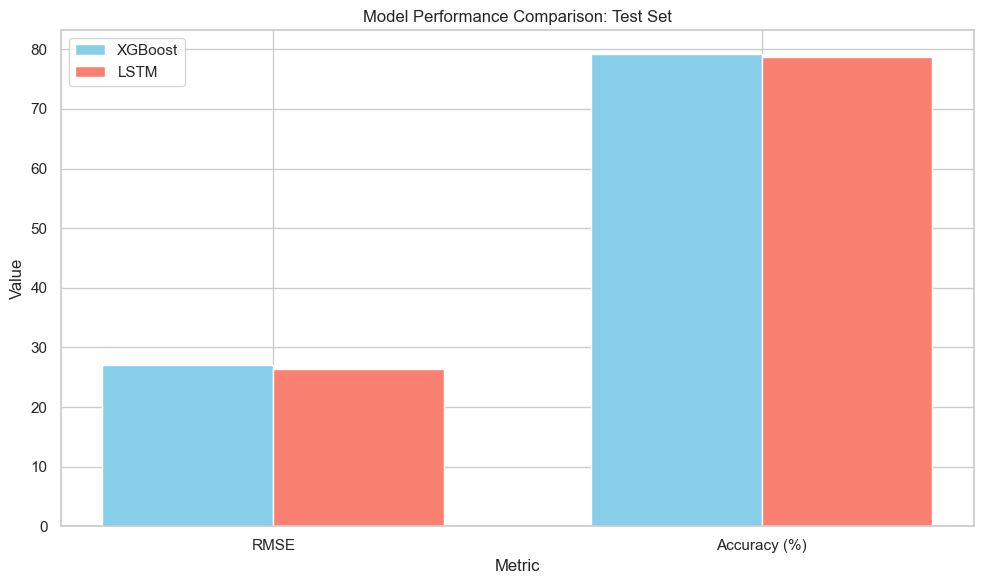

In [37]:
# Bar chart for RMSE and Accuracy
plt.figure(figsize=(10, 6))
metrics = ['RMSE', 'Accuracy (%)']
xgb_metrics = [rmse_xgb_test, accuracy_xgb_test]
lstm_metrics = [rmse_test_lstm, accuracy_test_lstm]
x = np.arange(len(metrics))
width = 0.35

plt.bar(x - width/2, xgb_metrics, width, label='XGBoost', color='skyblue')
plt.bar(x + width/2, lstm_metrics, width, label='LSTM', color='salmon')
plt.xlabel('Metric')
plt.ylabel('Value')
plt.title('Model Performance Comparison: Test Set')
plt.xticks(x, metrics)
plt.legend()
plt.tight_layout()
plt.show()

## save model

In [32]:
lstm_model.save('FD002_model.keras')